# QDS Hacks 2023
X-ecuters — Jan 6-8, 2023

Dataset from Teck: <br>
JSON - https://drive.google.com/file/d/1j-xR5BaXgwGAgUSI6BpNgZ__eUNt-7Vf/view <br>
CSV - https://drive.google.com/file/d/1pPHPwsk2qIO4sNk6VMayLEES6F9JcUr0/view

Goal: <br>
For a mining operation, find ways to move the same amount of material from the shovels to dumps with the least amount of fuel consumed.

In [292]:
# Import required libraries

import json
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 400)

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0)

from scipy import stats
from sklearn import model_selection, feature_selection, linear_model, naive_bayes, tree, metrics
from sklearn.feature_selection import SelectKBest, chi2

In [293]:
import sys
!conda install --yes --prefix {sys.prefix} palettable

Solving environment: done

## Package Plan ##

  environment location: /Users/tliang/opt/anaconda3

  added / updated specs:
    - palettable


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    palettable-3.3.0           |     pyhd3eb1b0_0          76 KB
    ------------------------------------------------------------
                                           Total:          76 KB

The following NEW packages will be INSTALLED:

  palettable         pkgs/main/noarch::palettable-3.3.0-pyhd3eb1b0_0 



                                                                                
Preparing transaction: done
Verifying transaction: done
Executing transaction: done


In [294]:
from palettable.colorbrewer.qualitative import Pastel1_7

---

## 1. Data Cleaning and Pre-Processing

In [233]:
# Load data as a DataFrame

df = pd.read_json('../Information/data_group0.json')

In [234]:
# Examine broadly

print(df.shape)
print(df.dtypes)
df.head()

(1928270, 12)
TIMESTAMP        datetime64[ns]
GPSNORTHING             float64
GPSEASTING              float64
GPSELEVATION            float64
FUEL_RATE               float64
STATUS                   object
PAYLOAD                 float64
TRUCK_ID                  int64
TRUCK_TYPE_ID             int64
SHOVEL_ID                 int64
DUMP_ID                   int64
RND                       int64
dtype: object


,TIMESTAMP,GPSNORTHING,GPSEASTING,GPSELEVATION,FUEL_RATE,STATUS,PAYLOAD,TRUCK_ID,TRUCK_TYPE_ID,SHOVEL_ID,DUMP_ID,RND
2,2022-04-03 00:01:04,55334.328779,224524.094341,402.9144,NaN,Empty,0.0,0,0,0,0,0
11,2022-04-03 00:01:22,55250.890875,224568.985459,402.3460,NaN,Empty,0.0,0,0,0,0,0
19,2022-04-03 00:01:38,55236.506152,224491.232652,400.4378,NaN,Empty,0.0,0,0,0,0,0
21,2022-04-03 00:01:42,55252.532868,224465.523704,398.0018,NaN,Empty,0.0,0,0,0,0,0
24,2022-04-03 00:01:48,55288.883906,224411.149771,392.3178,NaN,Empty,0.0,0,0,0,0,0


In [237]:
# Change Status and IDs to categorical data

col_names = ['STATUS', 'TRUCK_ID', 'TRUCK_TYPE_ID', 'SHOVEL_ID', 'DUMP_ID', 'RND']

for col in col_names:
    df[col] = df[col].astype('category')

print(df.dtypes)

df.describe(include='all')

TIMESTAMP        datetime64[ns]
GPSNORTHING             float64
GPSEASTING              float64
GPSELEVATION            float64
FUEL_RATE               float64
STATUS                 category
PAYLOAD                 float64
TRUCK_ID               category
TRUCK_TYPE_ID          category
SHOVEL_ID              category
DUMP_ID                category
RND                    category
dtype: object


/var/folders/yc/yfbtx3d16797zs0w20yxnbg40000gn/T/ipykernel_30487/1730630149.py:10: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  df.describe(include='all')


,TIMESTAMP,GPSNORTHING,GPSEASTING,GPSELEVATION,FUEL_RATE,STATUS,PAYLOAD,TRUCK_ID,TRUCK_TYPE_ID,SHOVEL_ID,DUMP_ID,RND
count,1928270,1.922458e+06,1.922458e+06,1.787980e+06,1.150583e+06,1928270,1.603583e+06,1928270.0,1928270.0,1928270.0,1928270.0,1928270.0
unique,344331,NaN,NaN,NaN,NaN,9,NaN,70.0,5.0,9.0,36.0,1.0
top,2022-04-04 07:43:22,NaN,NaN,NaN,NaN,NON_PRODUCTIVE,NaN,29.0,3.0,1.0,1.0,0.0
freq,18,NaN,NaN,NaN,NaN,669920,NaN,35335.0,1225307.0,421705.0,505219.0,1928270.0
first,2022-04-03 00:01:04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
last,2022-04-10 23:59:58,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,5.582938e+04,2.274633e+05,2.061853e+02,2.000197e+02,NaN,4.657667e+01,NaN,NaN,NaN,NaN,NaN
std,NaN,3.347236e+04,3.020521e+03,8.711676e+01,9.339684e+00,NaN,1.047352e+02,NaN,NaN,NaN,NaN,NaN
min,NaN,-5.978350e+06,2.224695e+05,-1.218000e+03,1.960000e+02,NaN,0.000000e+00,NaN,NaN,NaN,NaN,NaN
25%,NaN,5.519561e+04,2.274133e+05,1.358070e+02,1.965345e+02,NaN,0.000000e+00,NaN,NaN,NaN,NaN,NaN


In [238]:
# Check for duplicated rows

df[df.duplicated()]

,TIMESTAMP,GPSNORTHING,GPSEASTING,GPSELEVATION,FUEL_RATE,STATUS,PAYLOAD,TRUCK_ID,TRUCK_TYPE_ID,SHOVEL_ID,DUMP_ID,RND
34851,2022-04-03 21:01:22,55286.791031,224622.628466,403.4016,NaN,Hauling,NaN,0,0,0,0,0
322389,2022-04-04 01:44:46,55364.946353,224540.054957,402.1836,201.0945,Hauling,NaN,24,3,0,0,0
414895,2022-04-03 19:32:22,55359.116572,224576.130087,402.4678,200.2365,Hauling,NaN,33,3,0,0,0
486571,2022-04-03 20:01:04,55917.604637,224764.623802,356.6304,196.4300,Hauling,NaN,49,3,0,0,0
545535,2022-04-04 01:00:00,56158.601036,224491.709413,271.0862,205.6690,Hauling,286.130,21,3,3,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
19024264,2022-04-05 06:31:22,55930.742401,227026.833088,202.9594,198.2305,Hauling,NaN,41,3,7,25,0
19060877,2022-04-06 01:27:28,55731.118992,228645.261512,109.7824,196.4315,NON_PRODUCTIVE,0.000,12,3,5,25,0
19101041,2022-04-05 10:23:38,56395.323615,228530.123081,94.7604,196.0000,Empty,0.000,46,3,7,28,0
19173924,2022-04-08 21:12:38,56175.347867,228201.217907,140.1918,NaN,Hauling,248.287,42,4,2,21,0


In [239]:
# Drop duplicated rows (keep first by default)

df_dropDupes = df.copy()
df_dropDupes.drop_duplicates(inplace=True)
print(df_dropDupes.shape)

(1926432, 12)


In [240]:
# Drop rows with any null values

df_dropNA = df_dropDupes.copy()
df_dropNA.dropna(inplace=True)
print(df_dropNA.shape)

(846050, 12)


In [241]:
# Now that the data is cleaned, examine the dataset more closely

df_cleaned = df_dropNA.copy()
df_cleaned.describe(include='all')

/var/folders/yc/yfbtx3d16797zs0w20yxnbg40000gn/T/ipykernel_30487/2806241526.py:4: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  df_cleaned.describe(include='all')


,TIMESTAMP,GPSNORTHING,GPSEASTING,GPSELEVATION,FUEL_RATE,STATUS,PAYLOAD,TRUCK_ID,TRUCK_TYPE_ID,SHOVEL_ID,DUMP_ID,RND
count,846050,8.460500e+05,846050.000000,846050.000000,846050.000000,846050,846050.000000,846050.0,846050.0,846050.0,846050.0,846050.0
unique,317011,NaN,NaN,NaN,NaN,9,NaN,51.0,3.0,9.0,36.0,1.0
top,2022-04-09 14:49:34,NaN,NaN,NaN,NaN,Empty,NaN,30.0,3.0,1.0,1.0,0.0
freq,14,NaN,NaN,NaN,NaN,290093,NaN,29596.0,652011.0,237900.0,240777.0,846050.0
first,2022-04-03 00:01:38,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
last,2022-04-10 23:59:56,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,5.592527e+04,227709.247688,193.291732,199.037725,NaN,57.668816,NaN,NaN,NaN,NaN,NaN
std,NaN,2.639823e+04,2518.372268,85.593730,9.699030,NaN,112.115662,NaN,NaN,NaN,NaN,NaN
min,NaN,-5.978350e+06,222469.509778,-1218.000000,196.000000,NaN,0.000000,NaN,NaN,NaN,NaN,NaN
25%,NaN,5.520000e+04,227532.494718,113.030400,196.501500,NaN,0.000000,NaN,NaN,NaN,NaN,NaN


In [11]:
df_cleaned

,TIMESTAMP,GPSNORTHING,GPSEASTING,GPSELEVATION,FUEL_RATE,STATUS,PAYLOAD,TRUCK_ID,TRUCK_TYPE_ID,SHOVEL_ID,DUMP_ID,RND
65125,2022-04-03 14:47:16,55034.516453,222824.522779,366.2526,198.7570,Empty,0.0,3,3,0,0,0
65136,2022-04-03 14:47:38,55132.024813,222878.486122,364.5880,201.7380,Empty,0.0,3,3,0,0,0
65141,2022-04-03 14:47:48,55123.098526,222957.701274,364.5474,198.4345,Empty,0.0,3,3,0,0,0
65161,2022-04-03 14:48:28,55248.006549,223379.682400,363.2482,199.5020,Empty,0.0,3,3,0,0,0
65171,2022-04-03 14:48:48,55237.787494,223591.586468,361.6648,196.4355,Empty,0.0,3,3,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
19287754,2022-04-03 01:33:42,57653.850706,228928.973189,224.4368,196.5475,NON_PRODUCTIVE,0.0,32,3,4,4,0
19287771,2022-04-03 01:34:16,57654.499485,228929.729172,224.4368,196.5395,NON_PRODUCTIVE,0.0,32,3,4,4,0
19287788,2022-04-03 01:34:50,57655.888975,228929.391882,226.7104,196.5405,NON_PRODUCTIVE,0.0,32,3,4,4,0
19287790,2022-04-03 01:34:54,57656.488225,228929.220970,227.4412,196.6360,NON_PRODUCTIVE,0.0,32,3,4,4,0


In [124]:
df_cleaned.to_csv("data_group0_out.csv")

---

## 2. Data Analysis

In [242]:
df_copy = df_cleaned.copy()

### Getting the unique truck IDs and mapping them to the truck type

In [243]:
# How many unique trucks are recorded in this dataset
print(len(df_copy['TRUCK_ID'].unique()))

# List of unique trucks, sorted by ID
truck_list = np.sort(df_copy['TRUCK_ID'].unique()).tolist()
print(truck_list)

# Match each truck to its truck type ID
type_for_each_truck = []

for truck in truck_list:
    type_for_each_truck.append((truck, df_copy.loc[df_copy['TRUCK_ID'] == truck].iloc[0]['TRUCK_TYPE_ID']))
    
df_trucks = pd.DataFrame(type_for_each_truck, columns=['Truck','Truck Type']).set_index('Truck')
df_trucks

51
[1, 3, 4, 5, 6, 8, 9, 11, 12, 13, 14, 15, 17, 18, 21, 22, 23, 24, 25, 26, 27, 28, 30, 31, 32, 33, 34, 35, 36, 37, 39, 41, 43, 44, 46, 47, 49, 50, 51, 53, 54, 55, 56, 57, 61, 62, 63, 66, 67, 68, 69]


,Truck Type
Truck,
1,1
3,3
4,3
5,3
6,3
8,3
9,3
11,3
12,3


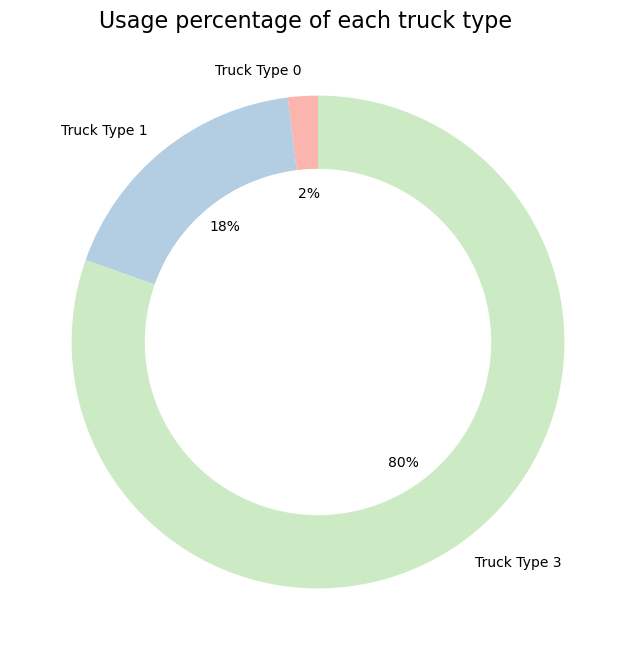

In [321]:
# Graph the percentage of each truck type as a pie chart
num_truck_type_0 = len(df_trucks[df_trucks['Truck Type'] == 0])
num_truck_type_1 = len(df_trucks[df_trucks['Truck Type'] == 1])
num_truck_type_3 = len(df_trucks[df_trucks['Truck Type'] == 3])

labels1 = ['Truck Type 0', 'Truck Type 1', 'Truck Type 3']
sizes1 = [num_truck_type_0, num_truck_type_1, num_truck_type_3]

my_circle = plt.Circle( (0,0), 0.7, color='white')

plt.pie(sizes1, labels=labels1, colors=Pastel1_7.hex_colors, autopct='%1.0f%%', startangle=90)
p = plt.gcf()
p.gca().add_artist(my_circle)
plt.suptitle('Usage percentage of each truck type', size=16, y=0.91)

plt.show()

### Payload analysis by truck type

In [286]:
payload_sum_truck_type_0 = sum(df_copy[df_copy['TRUCK_TYPE_ID'] == 0]['PAYLOAD'].unique())
print(payload_sum_truck_type_0)
payload_sum_truck_type_1 = sum(df_copy[df_copy['TRUCK_TYPE_ID'] == 1]['PAYLOAD'].unique())
print(payload_sum_truck_type_1)
payload_sum_truck_type_3 = sum(df_copy[df_copy['TRUCK_TYPE_ID'] == 3]['PAYLOAD'].unique())
print(payload_sum_truck_type_3)

payload_sum = payload_sum_truck_type_0 + payload_sum_truck_type_1 + payload_sum_truck_type_3
print('Sum: ' + str(payload_sum))

# Conclusion: Truck type 0 does not transport any payload throughout the week - inefficiency?

0.0
127897.98710000001
157995.3556999999
Sum: 285893.3427999999


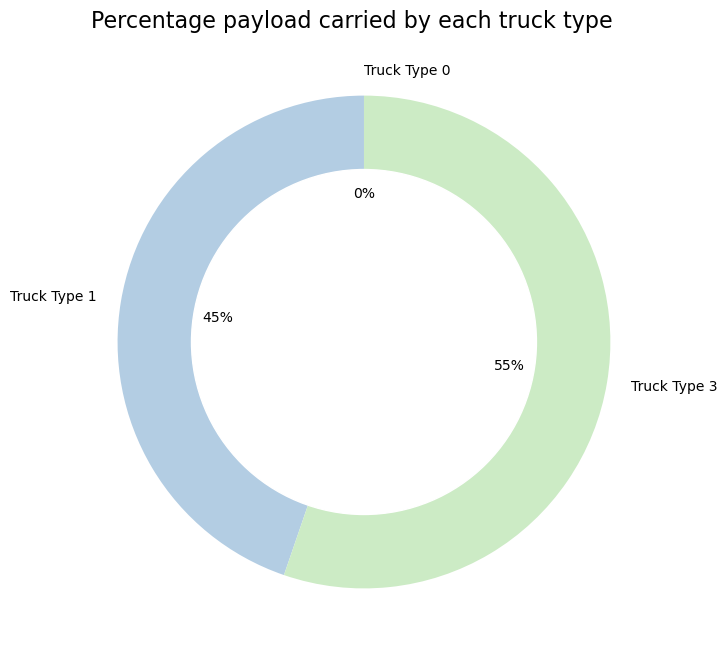

In [319]:
labels2 = ['Truck Type 0', 'Truck Type 1', 'Truck Type 3']
sizes2 = [payload_sum_truck_type_0, payload_sum_truck_type_1, payload_sum_truck_type_3]

my_circle = plt.Circle( (0,0), 0.7, color='white')

plt.pie(sizes2, labels=labels2, colors=Pastel1_7.hex_colors, autopct='%1.0f%%', startangle=90)
p = plt.gcf()
p.gca().add_artist(my_circle)
plt.suptitle('Percentage payload carried by each truck type', size=16, y=0.91)

plt.show()

### Finding the payload sum for each shovel to dump combination

In [314]:
# Create empty dictionary to hold shovel-dump combination (keys) and payload sum (values)
payload_dict = {}

# Loop through each unique value of shovel and dump to create combinations and calculate payload sum from unique payload values
for shovel in np.sort(df_copy['SHOVEL_ID'].unique()).tolist():
    for dump in np.sort(df_copy['DUMP_ID'].unique()).tolist():
        temp_str = "S" + str(shovel) + "-D" + str(dump)
        temp_df = df_copy[(df_copy['SHOVEL_ID'] == shovel) & (df_copy['DUMP_ID'] == dump)]
        payload_dict.update({temp_str: sum(temp_df['PAYLOAD'].unique())})

<AxesSubplot:title={'center':'Payload transferred from individual shovels to dumps'}, xlabel='Transferred amount', ylabel='Shovel to dump combination'>

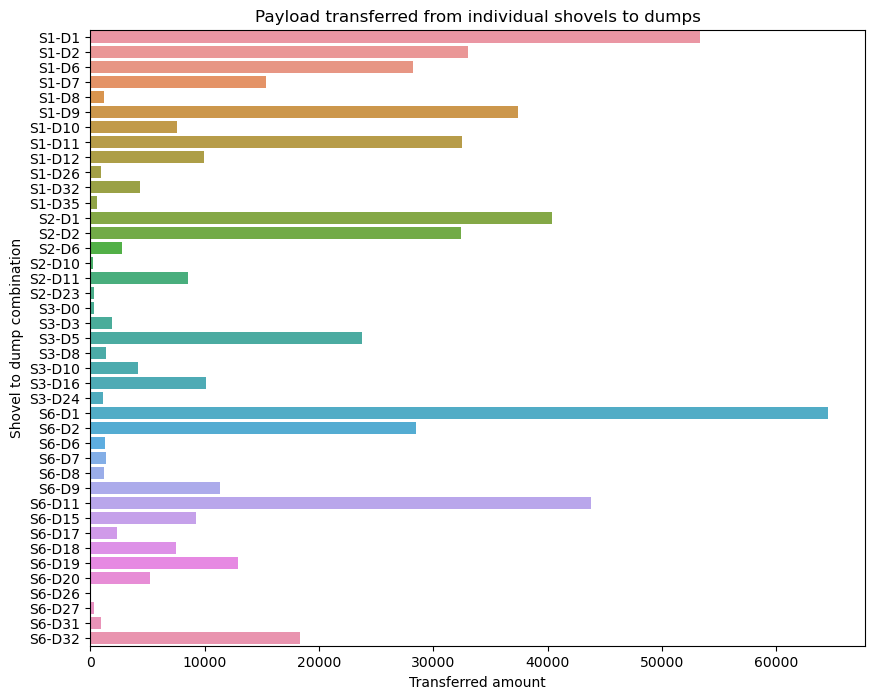

In [318]:
# Remove key-value pairs where the value is 0
payload_dict_dropZeroes = {x:y for x,y in payload_dict.items() if y!=0}

keys = list(payload_dict_dropZeroes.keys())
vals = [float(payload_dict_dropZeroes[k]) for k in keys]

payload_plot = sns.barplot(x=vals, y=keys)
payload_plot.set(xlabel='Transferred amount', ylabel='Shovel to dump combination', title='Payload transferred from individual shovels to dumps')
payload_plot

### Isolating records where status is 'NON_PRODUCTIVE' and the fuel burn rate is greater than 0

In [322]:
# Sort the cleaned dataset by timestamp
df_sorted_by_time = df_copy.sort_values(by='TIMESTAMP')
df_sorted_by_time

,TIMESTAMP,GPSNORTHING,GPSEASTING,GPSELEVATION,FUEL_RATE,STATUS,PAYLOAD,TRUCK_ID,TRUCK_TYPE_ID,SHOVEL_ID,DUMP_ID,RND
5121726,2022-04-03 00:01:38,52766.213888,227721.258575,242.9504,198.5940,Empty,0.0,1,1,1,1,0
5121735,2022-04-03 00:01:56,52875.660893,227736.411943,243.8842,199.1250,Empty,0.0,1,1,1,1,0
5121737,2022-04-03 00:02:00,52908.795867,227735.602293,244.2090,197.5985,Empty,0.0,1,1,1,1,0
5121743,2022-04-03 00:02:12,52989.588238,227715.272185,240.6768,196.9550,Empty,0.0,1,1,1,1,0
5121754,2022-04-03 00:02:34,53120.365935,227641.537540,229.0652,196.9550,Empty,0.0,1,1,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...
5634327,2022-04-10 23:59:52,52290.390883,227577.503278,239.7024,198.9925,Dumping,0.0,28,3,1,1,0
10057588,2022-04-10 23:59:54,55475.514369,228662.383043,112.4214,196.4885,Truck Loading,0.0,46,3,5,1,0
5634329,2022-04-10 23:59:56,52289.954430,227577.618190,239.5400,198.5080,Dumping,0.0,28,3,1,1,0
2054387,2022-04-10 23:59:56,56702.943192,224800.003132,225.4518,196.7625,Empty,0.0,14,3,3,3,0


In [323]:
# Reset indices
index = pd.Index(range(0, len(df_sorted_by_time), 1))
df_sorted_by_time = df_sorted_by_time.set_index(index)
df_sorted_by_time

,TIMESTAMP,GPSNORTHING,GPSEASTING,GPSELEVATION,FUEL_RATE,STATUS,PAYLOAD,TRUCK_ID,TRUCK_TYPE_ID,SHOVEL_ID,DUMP_ID,RND
0,2022-04-03 00:01:38,52766.213888,227721.258575,242.9504,198.5940,Empty,0.0,1,1,1,1,0
1,2022-04-03 00:01:56,52875.660893,227736.411943,243.8842,199.1250,Empty,0.0,1,1,1,1,0
2,2022-04-03 00:02:00,52908.795867,227735.602293,244.2090,197.5985,Empty,0.0,1,1,1,1,0
3,2022-04-03 00:02:12,52989.588238,227715.272185,240.6768,196.9550,Empty,0.0,1,1,1,1,0
4,2022-04-03 00:02:34,53120.365935,227641.537540,229.0652,196.9550,Empty,0.0,1,1,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...
846045,2022-04-10 23:59:52,52290.390883,227577.503278,239.7024,198.9925,Dumping,0.0,28,3,1,1,0
846046,2022-04-10 23:59:54,55475.514369,228662.383043,112.4214,196.4885,Truck Loading,0.0,46,3,5,1,0
846047,2022-04-10 23:59:56,52289.954430,227577.618190,239.5400,198.5080,Dumping,0.0,28,3,1,1,0
846048,2022-04-10 23:59:56,56702.943192,224800.003132,225.4518,196.7625,Empty,0.0,14,3,3,3,0


In [175]:
# Get the total elapsed non-productive time
target_status = "NON_PRODUCTIVE"
sum_nonproductive_time = 0

for index, row in df_sorted_by_time.iterrows():
    if index < len(df_sorted_by_time) and df_sorted_by_time.iloc[index]["STATUS"] == target_status and df_sorted_by_time.iloc[index+1]["STATUS"] == target_status:
        current_time = df_sorted_by_time.iloc[index]["TIMESTAMP"]
        next_time = df_sorted_by_time.iloc[index+1]["TIMESTAMP"]
        
        time_diff = np.datetime64(next_time) - np.datetime64(current_time)
        converted_time_diff_in_hrs = time_diff / np.timedelta64(1, 'h')
        
        sum_nonproductive_time += converted_time_diff_in_hrs

print('Total non-productive time in hrs: ' + str(sum_nonproductive_time))

Total non-productive time in hrs: 28.72722222219396


In [182]:
# Get the total elapsed time for dataset
total_start_time = df_sorted_by_time.iloc[0]["TIMESTAMP"]
total_end_time = df_sorted_by_time.iloc[-1]["TIMESTAMP"]
total_time_elapsed = np.datetime64(total_end_time) - np.datetime64(total_start_time)
coverted_total_time_elapsed_in_hrs = total_time_elapsed / np.timedelta64(1, 'h')

print('Total elapsed time in hrs: ' + str(coverted_total_time_elapsed_in_hrs))

# Percentage of non-productive time
percent = (sum_nonproductive_time / coverted_total_time_elapsed_in_hrs) * 100
print(f"Percentage of non-productive time: {percent:.2f}%")

Total elapsed time in hrs: 191.97166666666666
Percentage of non-productive time: 14.96%


### Separating each run into a DataFrame

In [78]:
index = pd.Index(range(0, 846050, 1))
df_new = df_copy.copy()
df_new = df_new.set_index(index)
df_new

,TIMESTAMP,GPSNORTHING,GPSEASTING,GPSELEVATION,FUEL_RATE,STATUS,PAYLOAD,TRUCK_ID,TRUCK_TYPE_ID,SHOVEL_ID,DUMP_ID,RND
0,2022-04-03 14:47:16,55034.516453,222824.522779,366.2526,198.7570,Empty,0.0,3,3,0,0,0
1,2022-04-03 14:47:38,55132.024813,222878.486122,364.5880,201.7380,Empty,0.0,3,3,0,0,0
2,2022-04-03 14:47:48,55123.098526,222957.701274,364.5474,198.4345,Empty,0.0,3,3,0,0,0
3,2022-04-03 14:48:28,55248.006549,223379.682400,363.2482,199.5020,Empty,0.0,3,3,0,0,0
4,2022-04-03 14:48:48,55237.787494,223591.586468,361.6648,196.4355,Empty,0.0,3,3,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
846045,2022-04-03 01:33:42,57653.850706,228928.973189,224.4368,196.5475,NON_PRODUCTIVE,0.0,32,3,4,4,0
846046,2022-04-03 01:34:16,57654.499485,228929.729172,224.4368,196.5395,NON_PRODUCTIVE,0.0,32,3,4,4,0
846047,2022-04-03 01:34:50,57655.888975,228929.391882,226.7104,196.5405,NON_PRODUCTIVE,0.0,32,3,4,4,0
846048,2022-04-03 01:34:54,57656.488225,228929.220970,227.4412,196.6360,NON_PRODUCTIVE,0.0,32,3,4,4,0


In [113]:
df_collection_run = []

temp_start_index = 0

# Create a list of run DataFrames
for index, row in df_new.iterrows():
    if (index < 846049) and ((df_new.iloc[index]["TRUCK_ID"] != df_new.iloc[index + 1]["TRUCK_ID"]) or (df_new.iloc[index]["TIMESTAMP"] > df_new.iloc[index + 1]["TIMESTAMP"]) or(((np.datetime64(df_new.iloc[index + 1]["TIMESTAMP"]) - np.datetime64(df_new.iloc[index]["TIMESTAMP"]))/np.timedelta64(1, 'm')) > 10)):
        df_collection_run.append(df_new.iloc[temp_start_index:index+1])
        temp_start_index = index + 1

### Looking at fuel consumption and non-productivity per run

In [214]:
fuel_consumption = []
sum_nonproductive_time_per_run = []
temp_sum = 0
counter = 0
target_status = 'NON_PRODUCTIVE'

for df_single in df_collection_run:
    # Calculate fuel consumption for each run
    avg_fuel_rate = sum(df_single['FUEL_RATE']) / len(df_single)
    
    start_time = df_single.iloc[0]['TIMESTAMP']
    end_time = df_single.iloc[-1]['TIMESTAMP']

    time_diff = np.datetime64(end_time) - np.datetime64(start_time)
    time_diff_in_hours = time_diff / np.timedelta64(1, 'h')
    
    fuel_consumption.append((counter,(avg_fuel_rate * time_diff_in_hours)))
    
    # Reset indices
    index = pd.Index(range(0, len(df_single), 1))
    df_single = df_single.set_index(index)
    
    # Calculate non-productive time for each run
    for index, row in df_single.iterrows():
        if (index < (len(df_single)-1)) and df_single.iloc[index]['STATUS'] == target_status and df_single.iloc[index+1]['STATUS'] == target_status:
            current_time = df_single.iloc[index]['TIMESTAMP']
            next_time = df_single.iloc[index+1]['TIMESTAMP']
        
            time_diff = np.datetime64(next_time) - np.datetime64(current_time)
            converted_time_diff_in_mins = time_diff / np.timedelta64(1, 'm')
        
            temp_sum += converted_time_diff_in_mins
            
    sum_nonproductive_time_per_run.append((df_single.iloc[0]['TRUCK_ID'],temp_sum))
    
    counter += 1
    temp_sum = 0

#### Plotting non-productive time per truck

In [215]:
sum_nonproductive_time_per_run

[(3, 0),
 (3, 19.633333333333333),
 (3, 0),
 (3, 127.96666666666664),
 (3, 0.2),
 (3, 14.666666666666664),
 (3, 4.1),
 (3, 22.06666666666667),
 (3, 23.966666666666676),
 (3, 0),
 (8, 0),
 (8, 16.666666666666664),
 (8, 2.7333333333333334),
 (8, 4.733333333333333),
 (8, 23.03333333333334),
 (8, 38.46666666666667),
 (8, 23.466666666666658),
 (8, 14.33333333333333),
 (8, 333.8000000000002),
 (8, 0),
 (8, 335.8000000000005),
 (12, 18.833333333333332),
 (12, 0),
 (12, 1.9666666666666666),
 (12, 0),
 (12, 0),
 (12, 39.733333333333334),
 (13, 0),
 (13, 31.266666666666687),
 (13, 0),
 (13, 0),
 (13, 0),
 (13, 0),
 (13, 12.233333333333334),
 (13, 22.66666666666667),
 (13, 20.333333333333332),
 (13, 44.60000000000003),
 (13, 3.4),
 (13, 6.5),
 (14, 0),
 (15, 0),
 (15, 0),
 (17, 35.73333333333332),
 (17, 0),
 (17, 18.233333333333338),
 (17, 34.599999999999994),
 (17, 95.49999999999997),
 (17, 0),
 (18, 0),
 (18, 10.766666666666667),
 (18, 14.166666666666666),
 (18, 0),
 (18, 109.10000000000002),
 

In [229]:
truck_id_to_unproductive_time = []

for unique_id in truck_list:
    temp_sum = 0
    for run in sum_nonproductive_time_per_run:
        if run[0] == unique_id:
            temp_sum += run[1]
    truck_id_to_unproductive_time.append((unique_id,temp_sum/60))
    
unique_truck = []
time_sum = []
    
for item in truck_id_to_unproductive_time:
    unique_truck.append(item[0])
    time_sum.append(item[1])

print(unique_truck)
print(time_sum)

[1, 3, 4, 5, 6, 8, 9, 11, 12, 13, 14, 15, 17, 18, 21, 22, 23, 24, 25, 26, 27, 28, 30, 31, 32, 33, 34, 35, 36, 37, 39, 41, 43, 44, 46, 47, 49, 50, 51, 53, 54, 55, 56, 57, 61, 62, 63, 66, 67, 68, 69]
[38.443888888888885, 35.72944444444443, 33.82888888888894, 30.18666666666666, 21.393333333333334, 25.196666666666676, 37.931111111111115, 39.59944444444443, 35.34999999999999, 32.842222222222226, 27.733888888888885, 32.39944444444445, 26.239999999999995, 35.69111111111112, 34.99111111111111, 32.26944444444445, 52.50055555555558, 25.031111111111112, 34.75388888888891, 55.23944444444448, 39.982222222222205, 19.53166666666667, 40.371111111111105, 40.70222222222221, 34.11444444444448, 41.80555555555561, 36.60055555555555, 16.462222222222223, 30.697777777777787, 40.81055555555554, 33.05166666666668, 36.727222222222316, 45.280555555555566, 39.45999999999999, 35.08444444444444, 36.96, 22.04944444444444, 40.9055555555555, 37.89111111111116, 34.60888888888891, 27.500555555555543, 22.05166666666666, 3

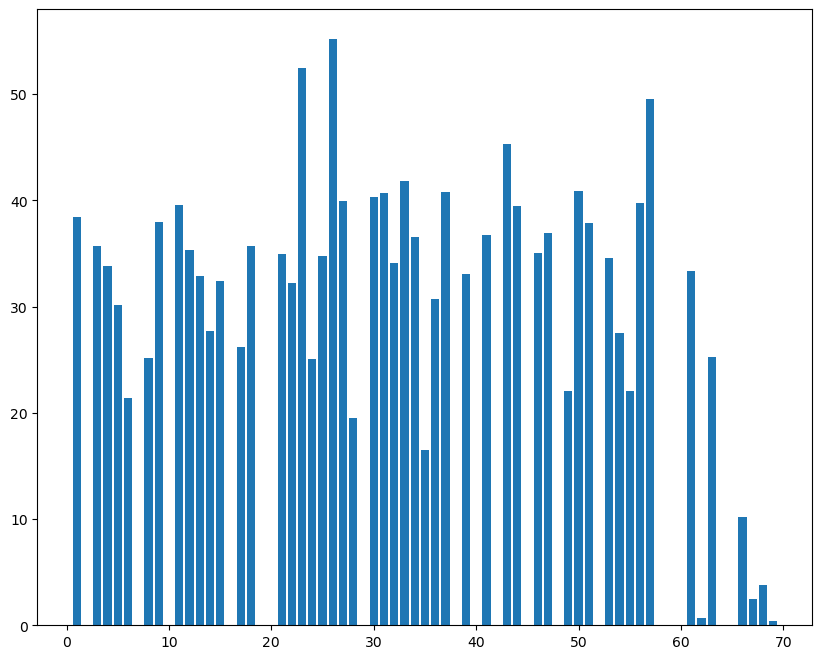

In [230]:
plt.figure()
plt.bar(unique_truck, time_sum)
plt.show()

#### Plotting fuel consumption per run against time elapsed per run

In [195]:
run_time_elapsed = []

for run in fuel_consumption:
    start_time = df_collection_run[run[0]].iloc[0]['TIMESTAMP']
    end_time = df_collection_run[run[0]].iloc[-1]['TIMESTAMP']
    
    time_diff = np.datetime64(end_time) - np.datetime64(start_time)
    converted_time_diff = time_diff / np.timedelta64(1, 'm')
    
    run_time_elapsed.append(converted_time_diff)

fuel_consump_list = []

for item in fuel_consumption:
    fuel_consump_list.append(item[1])

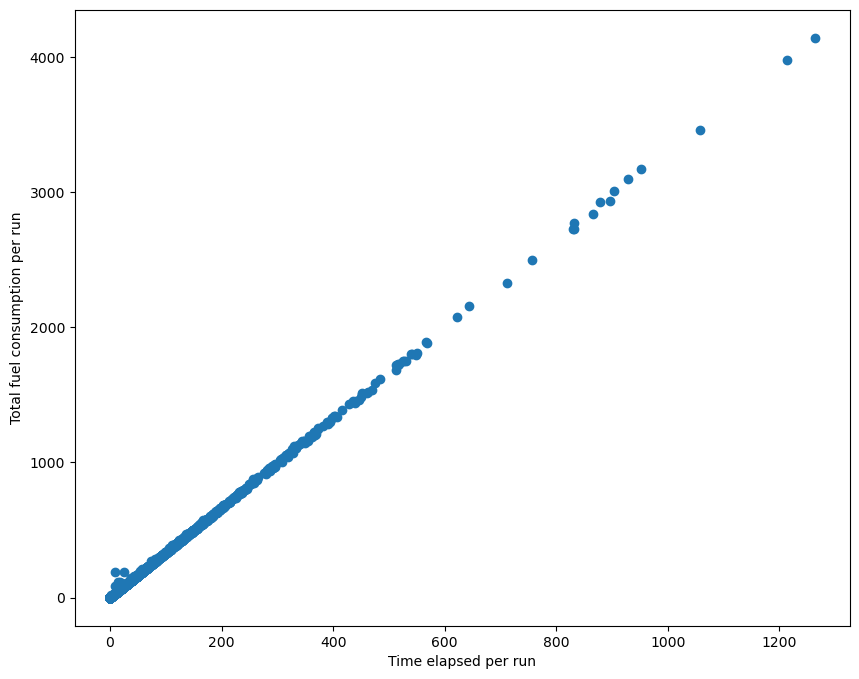

In [196]:
plt.figure()
plt.scatter(run_time_elapsed, fuel_consump_list)
plt.xlabel('Time elapsed per run')
plt.ylabel('Total fuel consumption per run')
plt.show()

### Examining all statuses (one haul cycle)

In [14]:
df_copy['STATUS'].unique()

['Empty', 'Queue At LU', 'Spot at LU', 'Truck Loading', 'Queuing at Dump', 'Dumping', 'NON_PRODUCTIVE', 'Wenco General Production', 'Hauling']
Categories (9, object): ['Dumping', 'Empty', 'Hauling', 'NON_PRODUCTIVE', ..., 'Queuing at Dump', 'Spot at LU', 'Truck Loading', 'Wenco General Production']

### Looking at data from shovel 0 to dump 0

Observation: payload values are all 0

In [17]:
shovel0_dump0 = df_copy.loc[(df_copy['SHOVEL_ID'] == 0) & (df_copy['DUMP_ID'] == 0)]
shovel0_dump0.describe(include='all')

/var/folders/yc/yfbtx3d16797zs0w20yxnbg40000gn/T/ipykernel_30487/2178381648.py:2: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  shovel0_dump0.describe(include='all')


,TIMESTAMP,GPSNORTHING,GPSEASTING,GPSELEVATION,FUEL_RATE,STATUS,PAYLOAD,TRUCK_ID,TRUCK_TYPE_ID,SHOVEL_ID,DUMP_ID,RND
count,25719,2.571900e+04,25719.000000,25719.000000,25719.000000,25719,25719.0,25719.0,25719.0,25719.0,25719.0,25719.0
unique,21723,NaN,NaN,NaN,NaN,8,NaN,21.0,1.0,1.0,1.0,1.0
top,2022-04-03 03:11:18,NaN,NaN,NaN,NaN,NON_PRODUCTIVE,NaN,41.0,3.0,0.0,0.0,0.0
freq,5,NaN,NaN,NaN,NaN,10165,NaN,4328.0,25719.0,25719.0,25719.0,25719.0
first,2022-04-03 00:09:32,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
last,2022-04-10 22:20:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,5.605035e+04,225015.478642,351.570562,197.388450,NaN,0.0,NaN,NaN,NaN,NaN,NaN
std,NaN,3.763593e+04,2827.972880,36.003732,1.733737,NaN,0.0,NaN,NaN,NaN,NaN,NaN
min,NaN,-5.978350e+06,222550.323246,-1218.000000,196.000000,NaN,0.0,NaN,NaN,NaN,NaN,NaN
25%,NaN,5.586887e+04,224736.837057,329.103600,196.506500,NaN,0.0,NaN,NaN,NaN,NaN,NaN


### Looking at data from shovel 1 to dump 1

Observation: some payload values are none-0

In [18]:
shovel1_dump1 = df_copy.loc[(df_copy['SHOVEL_ID'] == 1) & (df_copy['DUMP_ID'] == 1)]
shovel1_dump1.describe(include='all')

/var/folders/yc/yfbtx3d16797zs0w20yxnbg40000gn/T/ipykernel_30487/1112174425.py:2: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  shovel1_dump1.describe(include='all')


,TIMESTAMP,GPSNORTHING,GPSEASTING,GPSELEVATION,FUEL_RATE,STATUS,PAYLOAD,TRUCK_ID,TRUCK_TYPE_ID,SHOVEL_ID,DUMP_ID,RND
count,100968,1.009680e+05,100968.000000,100968.000000,100968.00000,100968,100968.000000,100968.0,100968.0,100968.0,100968.0,100968.0
unique,80514,NaN,NaN,NaN,NaN,8,NaN,48.0,2.0,1.0,1.0,1.0
top,2022-04-06 16:00:02,NaN,NaN,NaN,NaN,Hauling,NaN,36.0,3.0,1.0,1.0,0.0
freq,7,NaN,NaN,NaN,NaN,36621,NaN,8235.0,51173.0,100968.0,100968.0,100968.0
first,2022-04-03 00:01:38,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
last,2022-04-10 23:59:56,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,5.506398e+04,228196.489894,158.569066,200.09526,NaN,107.155411,NaN,NaN,NaN,NaN,NaN
std,NaN,1.904620e+04,1490.119546,55.907698,6.09368,NaN,145.322978,NaN,NaN,NaN,NaN,NaN
min,NaN,-5.978350e+06,222645.228386,-1218.000000,196.00000,NaN,0.000000,NaN,NaN,NaN,NaN,NaN
25%,NaN,5.366249e+04,227669.179900,101.743600,196.54500,NaN,0.000000,NaN,NaN,NaN,NaN,NaN


### Drop all records where payload = 0

In [19]:
df_dropZeroes = df_copy.loc[(df_copy['PAYLOAD'] > 0)]
df_dropZeroes

,TIMESTAMP,GPSNORTHING,GPSEASTING,GPSELEVATION,FUEL_RATE,STATUS,PAYLOAD,TRUCK_ID,TRUCK_TYPE_ID,SHOVEL_ID,DUMP_ID,RND
545326,2022-04-04 00:53:04,57067.062646,224628.640788,190.1298,198.4070,Hauling,286.130,21,3,3,0,0
545330,2022-04-04 00:53:12,57076.464211,224648.069297,190.6982,197.8905,Hauling,286.130,21,3,3,0,0
545333,2022-04-04 00:53:18,57094.988793,224662.585234,192.4440,202.2155,Hauling,286.130,21,3,3,0,0
545338,2022-04-04 00:53:28,57140.311558,224671.341439,194.0274,204.8810,Hauling,286.130,21,3,3,0,0
545357,2022-04-04 00:54:06,57270.154964,224868.941533,195.6108,205.2720,Hauling,286.130,21,3,3,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
19257726,2022-04-04 14:07:54,54872.453497,228798.833907,212.6628,197.8565,Hauling,351.663,36,1,2,23,0
19257763,2022-04-04 14:09:08,54674.642311,228747.667719,206.7352,196.9865,Hauling,351.663,36,1,2,23,0
19257771,2022-04-04 14:09:24,54643.293187,228738.396373,203.8526,196.9160,Hauling,351.663,36,1,2,23,0
19257793,2022-04-04 14:10:08,54558.852517,228723.248641,201.3354,198.0465,Hauling,351.663,36,1,2,23,0


### Correlation analysis

In [25]:
df_copy.corr()

,GPSNORTHING,GPSEASTING,GPSELEVATION,FUEL_RATE,PAYLOAD
GPSNORTHING,1.000000,-0.758233,0.070393,-0.001846,-0.008219
GPSEASTING,-0.758233,1.000000,-0.414013,0.002494,0.004730
GPSELEVATION,0.070393,-0.414013,1.000000,0.005249,-0.018544
FUEL_RATE,-0.001846,0.002494,0.005249,1.000000,0.276234
PAYLOAD,-0.008219,0.004730,-0.018544,0.276234,1.000000


<AxesSubplot:>

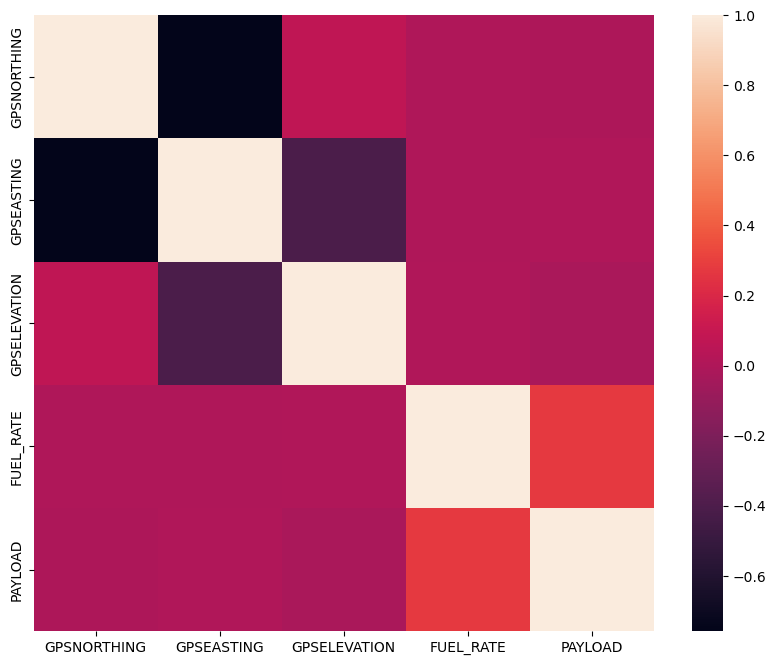

In [26]:
sns.heatmap(df_copy.corr())

In [28]:
# Shapiro-Wilk tests for numerical predictors

print(stats.shapiro(df_copy['GPSNORTHING']))
print(stats.shapiro(df_copy['GPSEASTING']))
print(stats.shapiro(df_copy['GPSELEVATION']))
print(stats.shapiro(df_copy['FUEL_RATE']))

ShapiroResult(statistic=0.00784987211227417, pvalue=0.0)
ShapiroResult(statistic=0.34157800674438477, pvalue=0.0)
ShapiroResult(statistic=0.9215213060379028, pvalue=0.0)
ShapiroResult(statistic=0.12600916624069214, pvalue=0.0)


/Users/tliang/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_morestats.py:1800: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


In [41]:
df_categorical = df_copy.filter(['FUEL_RATE','STATUS','TRUCK_ID', 'TRUCK_TYPE_ID'], axis=1)

df_categorical = pd.get_dummies(df_categorical, columns=['STATUS','TRUCK_ID', 'TRUCK_TYPE_ID'], 
                                                prefix=['status', 'truck', 'truckType'])

df_categorical['FR_LT_AVG'] = 1
df_categorical.loc[df_categorical['FUEL_RATE'] >= 199.037725, 'FR_LT_AVG'] = 0

df_categorical

,FUEL_RATE,status_Dumping,status_Empty,status_Hauling,status_NON_PRODUCTIVE,status_Queue At LU,status_Queuing at Dump,status_Spot at LU,status_Truck Loading,status_Wenco General Production,truck_1,truck_3,truck_4,truck_5,truck_6,truck_8,truck_9,truck_11,truck_12,truck_13,truck_14,truck_15,truck_17,truck_18,truck_21,truck_22,truck_23,truck_24,truck_25,truck_26,truck_27,truck_28,truck_30,truck_31,truck_32,truck_33,truck_34,truck_35,truck_36,truck_37,truck_39,truck_41,truck_43,truck_44,truck_46,truck_47,truck_49,truck_50,truck_51,truck_53,truck_54,truck_55,truck_56,truck_57,truck_61,truck_62,truck_63,truck_66,truck_67,truck_68,truck_69,truckType_0,truckType_1,truckType_3,FR_LT_AVG
65125,198.7570,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1
65136,201.7380,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
65141,198.4345,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1
65161,199.5020,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
65171,196.4355,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19287754,196.5475,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1
19287771,196.5395,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1
19287788,196.5405,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1
19287790,196.6360,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1


<AxesSubplot:xlabel='Predictor', ylabel='Score'>

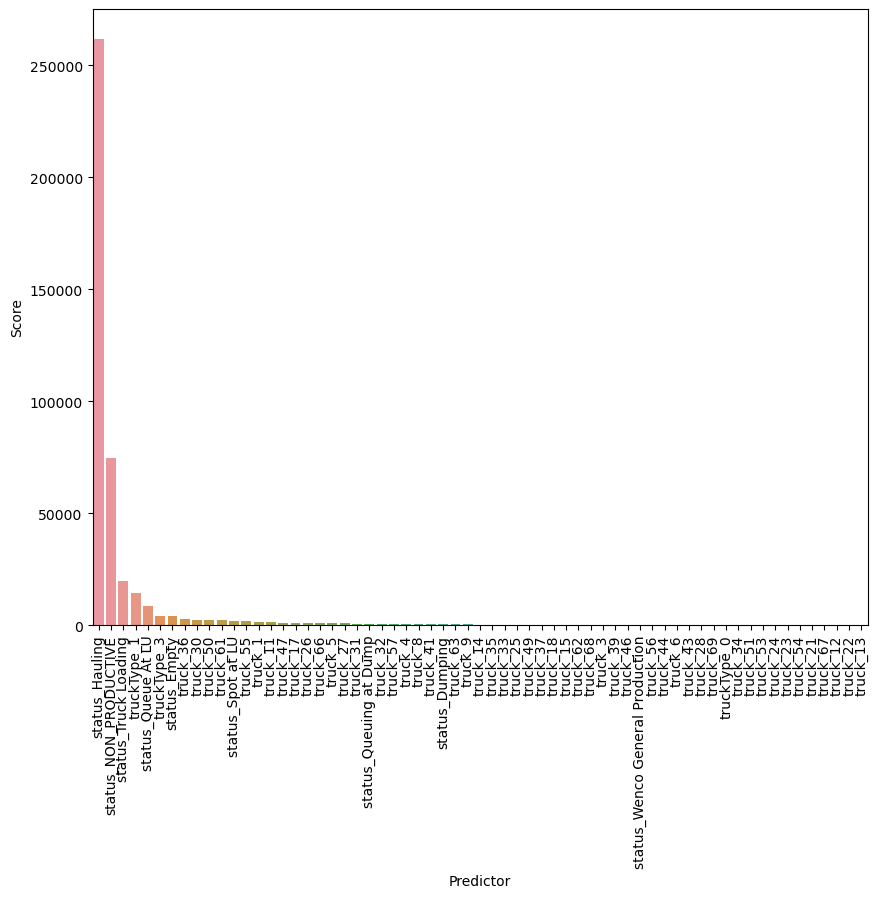

In [48]:
# Chi-squared test for categorical predictors

X_chi2 = df_categorical.iloc[:,1:-1]
y_chi2 = df_categorical['FR_LT_AVG']

df_chi2 = SelectKBest(chi2, k='all')
df_chi2.fit(X_chi2, y_chi2)

chi2_scores = pd.DataFrame({'Predictor': X_chi2.columns,'Score': df_chi2.scores_})
chi2_scores.sort_values(by='Score', ascending=False, inplace=True)

#print(chi2_scores)

chi2_plot = sns.barplot(x=chi2_scores['Predictor'], y=chi2_scores['Score'])
chi2_plot.set_xticklabels(chi2_plot.get_xticklabels(), rotation=90)
chi2_plot

### Making DataFrames for each truck where the status is "NON_PRODUCTIVE"

In [ ]:
df_idle = {}

for truck in truck_list:
    df_idle[truck] = df_copy.loc[(df_copy['STATUS'] == 'NON_PRODUCTIVE') & (df_copy['TRUCK_ID'] == truck)]

df_idle[1].describe(include='all')

### Making DataFrames for each truck in general

In [ ]:
df_collection = {}

for truck in truck_list:
    df_collection[truck] = df_copy.loc[(df_copy['TRUCK_ID'] == truck)]

df_collection[1].describe(include='all')